<a href="https://colab.research.google.com/github/datacommonsorg/api-python/blob/master/notebooks/intro_data_science/Regression_Basics_and_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2022 Google LLC.
SPDX-License-Identifier: Apache-2.0


# Regression: Basics and Prediction

[Regression analysis](https://en.wikipedia.org/wiki/Regression_analysis) is a powerful process for finding statistical relationships between variables. It's one of the most commonly used tools seen in the data science world, often used for prediction and forecasting.

In this assignment, we'll be focusing on [linear regression](https://en.wikipedia.org/wiki/Linear_regression), which forms the basis for most regression models. In particular, we'll explore linear regression as a tool for _prediction_. We'll cover _interpreting_ regression models, in part 2.

### Learning Objectives:
* Linear regression for prediction
* Mean-Squared error
* In-sample vs out-of-sample prediction
* Single variate vs. multivariate Regression
* The effect of increasing variables

---
**Need extra help?**

If you're new to Google Colab, take a look at [this getting started tutorial](https://colab.research.google.com/notebooks/intro.ipynb).

To build more familiarity with the Data Commons API, check out these [Data Commons Tutorials](https://docs.datacommons.org/tutorials/).

And for help with Pandas and manipulating data frames, take a look at the [Pandas Documentation](https://pandas.pydata.org/docs/reference/index.html).

We'll be using the scikit-learn library for implementing our models today. Documentation can be found [here](https://scikit-learn.org/stable/modules/classes.html). 

As usual, if you have any other questions, please reach out to your course staff!

# Part 0: Getting Set Up

Run the following code boxes to load the python libraries and data we'll be using today.

In [ ]:
# Setup/Imports
!pip install datacommons --upgrade --quiet
!pip install datacommons_pandas --upgrade --quiet

In [ ]:
# Data Commons Python and Pandas APIs
import datacommons
import datacommons_pandas

# For manipulating data
import numpy as np
import pandas as pd

# For implementing models and evaluation methods
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error

# For plotting/printing
from matplotlib import pyplot as plt
import seaborn as sns

## Introduction

In this assignment, we'll be returning to the scenario we started analyzing in the Model Evaluation assignment -- analyzing the [obesity epidemic in the United States](https://en.wikipedia.org/wiki/Obesity_in_the_United_States). Obesity rates vary across the nation by geographic location. In this colab, we'll be exploring how obesity rates vary with different health or societal factors across US cities.

In the Model Evaluation assignment, we limited our analysis to high (<30%) and low (>30%) categories. Today we'll go one step further and predict the obesity rates themselves.

Our data science question: **Can we predict the obesity rates of various US Cities based on other health or lifestyle factors?**

---

Run the following code box to load the data. We've done some basic data cleaning and manipulation for you, but look through the code to make sure you understand what's going on.

In [ ]:
# Load the data we'll be using
city_dcids = datacommons.get_property_values(["CDC500_City"],
                                             "member",
                                             limit=500)["CDC500_City"]

# We've compiled a list of some nice Data Commons Statistical Variables
# to use as features for you
stat_vars_to_query = [
  "Count_Person",
  "Percent_Person_PhysicalInactivity",
  "Percent_Person_SleepLessThan7Hours",
  "Percent_Person_WithHighBloodPressure",
  "Percent_Person_WithMentalHealthNotGood",
  "Percent_Person_WithHighCholesterol",
  "Percent_Person_Obesity"
                      
]

# Query Data Commons for the data and remove any NaN values
raw_features_df = datacommons_pandas.build_multivariate_dataframe(city_dcids,stat_vars_to_query)
raw_features_df.dropna(inplace=True)

# order columns alphabetically
raw_features_df = raw_features_df.reindex(sorted(raw_features_df.columns), axis=1)

# Add city name as a column for readability.
# --- First, we'll get the "name" property of each dcid
# --- Then add the returned dictionary to our data frame as a new column
df = raw_features_df.copy(deep=True)
city_name_dict = datacommons.get_property_values(city_dcids, 'name')
city_name_dict = {key:value[0] for key, value in city_name_dict.items()}
df.insert(0, 'City Name', pd.Series(city_name_dict))

# Display results
display(df)

,City Name,Count_Person,Percent_Person_Obesity,Percent_Person_PhysicalInactivity,Percent_Person_SleepLessThan7Hours,Percent_Person_WithHighBloodPressure,Percent_Person_WithHighCholesterol,Percent_Person_WithMentalHealthNotGood
place,,,,,,,,
geoId/0107000,Birmingham,200733,40.1,33.9,44.0,44.9,34.6,17.4
geoId/0135896,Hoover,92606,28.8,20.2,33.4,32.4,33.2,12.0
geoId/0137000,Huntsville,215006,34.7,28.4,38.7,37.4,33.5,15.4
geoId/0150000,Mobile,187041,38.0,29.9,41.0,42.2,35.2,16.3
geoId/0151000,Montgomery,200603,36.7,30.7,42.6,41.2,34.5,17.0
...,...,...,...,...,...,...,...,...
geoId/5548000,Madison,269840,24.9,17.1,31.2,22.1,28.2,13.0
geoId/5553000,Milwaukee,577222,38.9,28.9,38.8,31.2,29.9,16.6
geoId/5566000,Racine,77816,43.2,28.8,36.7,31.6,33.1,15.1


## Questions

**Q0A)** Look through the dataframe and make sure you understand what each variable is describing.

**Q0B)** What are the units for each variable?

# Part 1: Single Linear Regression

To help us build some intuition for how regression works, we'll start by using a single variable. We'll create two models, Model A and Model B. Model A will use `Count_Person` variable to predict obesity rates, while Model B will use the `Percent_Person_PhysicalInactivity` variable.

Model | Independent Variable | Dependent Variable
--- | --- | ---
Model A | `Count_Person` | `Percent_Person_Obesity`
Model B | `Percent_Person_PhysicalInactivity` | `Percent_Person_Obesity`

**Q1A)** Just using your intuition, which model do you think will be better at predicting obesity rates? Why?



## Fit a Model
Let's now check your intuition by fitting linear regression models to our data.

Run the following code box to fit Model A and Model B.

Model A:
---------
Weights: [[-2.52769403e-07]]
Intercept: [30.73930718]


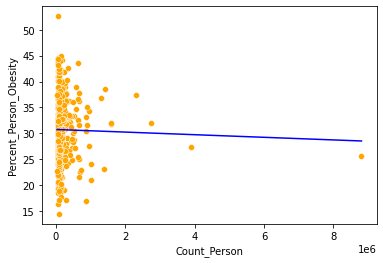

Model B:
---------
Weights: [[0.7977576]]
Intercept: [11.4806282]


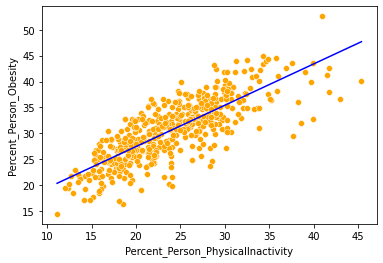

In [ ]:
var1 = "Count_Person"
var2 = "Percent_Person_PhysicalInactivity"
dep_var = "Percent_Person_Obesity"

df_single_vars = df[[var1, var2, dep_var]].copy()
x_a = df_single_vars[var1].to_numpy().reshape(-1, 1)
x_b = df_single_vars[var2].to_numpy().reshape(-1,1)
y = df_single_vars[dep_var].to_numpy().reshape(-1, 1)

# Fit models
model_a = linear_model.LinearRegression().fit(x_a,y)
model_b = linear_model.LinearRegression().fit(x_b,y)

# Make Predictions
predictions_a = model_a.predict(x_a)
predictions_b = model_b.predict(x_b)
df_single_vars["Prediction_A"] = predictions_a
df_single_vars["Prediction_B"] = predictions_b

# Plot Model A
print("Model A:")
print("---------")
print("Weights:", model_a.coef_)
print("Intercept:", model_a.intercept_)
fig, ax = plt.subplots()
p1 = sns.scatterplot(data=df_single_vars, x=var1, y=dep_var, ax=ax, color="orange")
p2 = sns.lineplot(data=df_single_vars, x=var1, y="Prediction_A", ax=ax, color="blue")
plt.show()

# Plot Model B
print("Model B:")
print("---------")
print("Weights:", model_b.coef_)
print("Intercept:", model_b.intercept_)
fig, ax = plt.subplots()
p1 = sns.scatterplot(data=df_single_vars, x=var2, y=dep_var, ax=ax, color="orange")
p2 = sns.lineplot(data=df_single_vars, x=var2, y="Prediction_B", ax=ax, color="blue")
plt.show()

**Q1B**) For each model, what are the units of the weights? Intercepts?

**Q1C**) Mathematically, what does the weight represent?

**Q1D**) Mathematically, what does the intercept represent?

**Q1E**) Looking visually at the plots of the regression models, which model do you think will be better at predicting obesity rates for new, unseen data points (cities)? Why?

## Prediction Error: MSE and RMSE

To quantify predictive accuracy, we find the prediction error, a metric of how far off our model predictions are from the true value. One of the most common metrics used is [mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error):


$$ MSE = \frac{1}{\text{# total data points}}\sum_{\text{all data points}}(\text{predicted value} - \text{actual value})^2$$

MSE is a measure of the average difference between the predicted value and the actual value. The square ($^2$) can seem counterintuitive at first, but offers some nice mathematical properties.

There's also [root mean squared error](https://en.wikipedia.org/wiki/Root-mean-square_deviation), the square root of the MSE, which scales the error metric to match the scale of the data points:

$$ RMSE = \sqrt{MSE} = \sqrt{\frac{1}{\text{# total data points}}\sum_{\text{all data points}}(\text{predicted value} - \text{actual value})^2}$$


Prediction error can actually refer to one of two things: _in-sample prediction error_ or _out-of-sample prediction error_. We'll explore both in the sections below.


### In-Sample Prediction

In-sample prediction refers to forecasting or predicting for a data point that was used to fit the model. This is akin to applying your model to the training set, in machine learning parlance. In-sample prediction error measures how well our model is able to reproduce the data we currently have. 

Run the following code block to calculate the in-sample prediction RMSE for both models.

In [ ]:
print("Model A RMSE:", mean_squared_error(y, predictions_a, squared=False))
print("Model B RMSE:", mean_squared_error(y, predictions_b, squared=False))

Model A RMSE: 5.936696215465063
Model B RMSE: 3.5835889375814243


**Q1F)** What are the units of the RMSE for each model?

**Q1G)** Which model had better RMSE?

### Out-Of-Sample Prediction
In contrast to in-sample prediction, we can also perform _out-of-sample_ prediction, by using our model to make predictions on new, previously unseen data. This is akin to applying our model on a test set, in machine learning parlance. Out-of-sample prediction error measures how well our model can generalize to new data.

**Q1H)** In general, would you expect in-sample prediction error, or out-of-sample prediction error to be higher?

Let's see how well our models perform on some US cities not included in the CDC500.


Model A:
--------


,Model A Prediction,Percent_Person_Obesity
place,,
geoId/0236400,30.731154,25.3
geoId/0617610,30.724045,14.6
geoId/2467675,30.722342,22.6
geoId/3103950,30.723085,38.8
geoId/4530850,30.721431,31.6


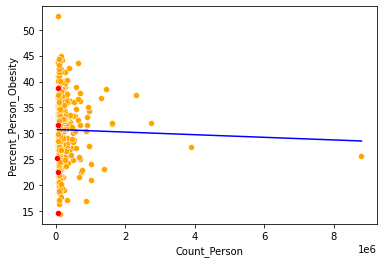

RMSE: 9.181101511317916

Model B:
--------


,Model B Prediction,Percent_Person_Obesity
place,,
geoId/0236400,25.521162,25.3
geoId/0617610,22.569459,14.6
geoId/2467675,25.441386,22.6
geoId/3103950,30.706586,38.8
geoId/4530850,29.829053,31.6


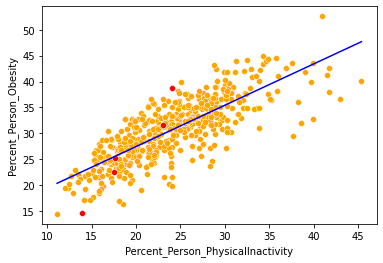

RMSE: 5.296683114305785



In [ ]:
# make a prediction
new_dcids = [
  "geoId/0617610", # Cupertino, CA
  "geoId/0236400", # Juneau, AK
  "geoId/2467675", # Rockville, MD
  "geoId/4530850", # Greenville, SC
  "geoId/3103950", # Bellevue, NE
]
new_df = datacommons_pandas.build_multivariate_dataframe(new_dcids,stat_vars_to_query)

x_a_new = new_df[var1].to_numpy().reshape(-1,1)
x_b_new = new_df[var2].to_numpy().reshape(-1,1)
y_new = new_df[dep_var].to_numpy().reshape(-1, 1)

predicted_a_new = model_a.predict(x_a_new)
predicted_b_new = model_b.predict(x_b_new)
new_df["Model A Prediction"] = predicted_a_new
new_df["Model B Prediction"] = predicted_b_new

print("Model A:")
print("--------")
display(new_df[["Model A Prediction", dep_var]])
fig, ax = plt.subplots()
p0 = sns.scatterplot(data=df_single_vars, x=var1, y=dep_var, ax=ax, color="orange")
p1 = sns.scatterplot(data=new_df, x=var1, y=dep_var, ax=ax, color="red")
p2 = sns.lineplot(data=df_single_vars, x=var1, y="Prediction_A", ax=ax, color="blue")
plt.show()
print("RMSE:", mean_squared_error(y_new, predicted_a_new, squared=False))
print("")

print("Model B:")
print("--------")
display(new_df[["Model B Prediction", dep_var]])
fig, ax = plt.subplots()
p0 = sns.scatterplot(data=df_single_vars, x=var2, y=dep_var, ax=ax, color="orange")
p1 = sns.scatterplot(data=new_df, x=var2, y=dep_var, ax=ax, color="red")
p2 = sns.lineplot(data=df_single_vars, x=var2, y="Prediction_B", ax=ax, color="blue")
plt.show()
print("RMSE:", mean_squared_error(y_new, predicted_b_new, squared=False))
print("")


**Q1I)** How well did these model predict the obesity rates? Which model had better accuracy?

**Q1J)** For the model you selected in the question above, how much would you trust this model? What are its limitations?

**Q1K)**Can you think of any ways to create an even better model?


# Part 2: Multiple Linear Regression

Let's now see what happens if we increase the number of independent variables used to make our prediction. Using multiple independent variables is referred to as _multiple linear regression_.

Now let's use all the data we loaded at the beginning of the assignment. The following code box will display our dataframe in its entirety again, so you can refamiliarize yourself with the data we have available.

In [ ]:
display(df)

,City Name,Count_Person,Percent_Person_Obesity,Percent_Person_PhysicalInactivity,Percent_Person_SleepLessThan7Hours,Percent_Person_WithHighBloodPressure,Percent_Person_WithHighCholesterol,Percent_Person_WithMentalHealthNotGood
place,,,,,,,,
geoId/0107000,Birmingham,200733,40.1,33.9,44.0,44.9,34.6,17.4
geoId/0135896,Hoover,92606,28.8,20.2,33.4,32.4,33.2,12.0
geoId/0137000,Huntsville,215006,34.7,28.4,38.7,37.4,33.5,15.4
geoId/0150000,Mobile,187041,38.0,29.9,41.0,42.2,35.2,16.3
geoId/0151000,Montgomery,200603,36.7,30.7,42.6,41.2,34.5,17.0
...,...,...,...,...,...,...,...,...
geoId/5548000,Madison,269840,24.9,17.1,31.2,22.1,28.2,13.0
geoId/5553000,Milwaukee,577222,38.9,28.9,38.8,31.2,29.9,16.6
geoId/5566000,Racine,77816,43.2,28.8,36.7,31.6,33.1,15.1


## Fit a Model

Now let's fit a linear regression model using all of the features in our dataframe. 

In [ ]:
# fit a regression model
dep_var = "Percent_Person_Obesity"

y = df[dep_var].to_numpy().reshape(-1, 1)
x = df.loc[:, ~df.columns.isin([dep_var, "City Name"])]

model = linear_model.LinearRegression().fit(x,y)
predictions = model.predict(x)
df["Predicted"] = predictions

print("Features in Order:\n\n\t", x.columns)
print("\nWeights:\n\n\t", model.coef_)
print("\nIntercept:\n\n\t", model.intercept_)

Features in Order:

	 Index(['Count_Person', 'Percent_Person_PhysicalInactivity',
       'Percent_Person_SleepLessThan7Hours',
       'Percent_Person_WithHighBloodPressure',
       'Percent_Person_WithHighCholesterol',
       'Percent_Person_WithMentalHealthNotGood'],
      dtype='object')

Weights:

	 [[-3.38643952e-07  4.12927909e-01 -1.22522892e-01  4.76800491e-01
  -2.52975071e-01  7.07563946e-01]]

Intercept:

	 [8.99990946]


**Q2A)** Look at the coefficients for each of the features. Which features contribute most to the prediction?

## Prediction Error
Let's now analyze the in-sample and out-of-sample prediction error for our multiple linear regression model.

In [ ]:
# Analyze in sample MSE
print("In-sample Prediction RMSE:", mean_squared_error(y, predictions, squared=False))

In-sample Prediction RMSE: 3.164318046572118


**Q2B)** How does the in-sample prediction RMSE compare with that of the single variable models A and B?

We'll also take a look at out-of-sample prediction error.

In [ ]:
# Apply model to some out-of-sample datapoints
new_dcids = [
  "geoId/0617610", # Cupertino, CA
  "geoId/0236400", # Juneau, AK
  "geoId/2467675", # Rockville, MD
  "geoId/4530850", # Greenville, SC
  "geoId/3103950", # Bellevue, NE
]
new_df = datacommons_pandas.build_multivariate_dataframe(new_dcids,stat_vars_to_query)

# sort columns alphabetically
new_df = new_df.reindex(sorted(new_df.columns), axis=1)

# Add city name as a column for readability.
# --- First, we'll get the "name" property of each dcid
# --- Then add the returned dictionary to our data frame as a new column
new_df = new_df.copy(deep=True)
city_name_dict = datacommons.get_property_values(new_dcids, 'name')
city_name_dict = {key:value[0] for key, value in city_name_dict.items()}
new_df.insert(0, 'City Name', pd.Series(city_name_dict))

display(new_df)

new_y = new_df[dep_var].to_numpy().reshape(-1, 1)
new_x = new_df.loc[:, ~new_df.columns.isin([dep_var, "City Name"])]

predicted = model.predict(new_x)
new_df["Prediction"] = predicted
display(new_df[["Prediction", dep_var]])


,City Name,Count_Person,Percent_Person_Obesity,Percent_Person_PhysicalInactivity,Percent_Person_SleepLessThan7Hours,Percent_Person_WithHighBloodPressure,Percent_Person_WithHighCholesterol,Percent_Person_WithMentalHealthNotGood
place,,,,,,,,
geoId/0236400,Juneau,32255,25.3,17.6,34.2,29.6,30.3,12.2
geoId/0617610,Cupertino,60381,14.6,13.9,30.0,23.9,29.6,7.1
geoId/2467675,Rockville,67117,22.6,17.5,32.7,27.1,34.0,9.6
geoId/3103950,Bellevue,64176,38.8,24.1,32.6,31.1,31.7,11.1
geoId/4530850,Greenville,70720,31.6,23.0,35.5,32.2,32.7,13.5


,Prediction,Percent_Person_Obesity
place,,
geoId/0236400,27.146665,25.3
geoId/0617610,19.974647,14.6
geoId/2467675,23.309675,22.6
geoId/3103950,29.598638,38.8
geoId/4530850,30.756544,31.6


In [ ]:
print("Out-of-sample RMSE:", mean_squared_error(new_y, predicted, squared=False))

Out-of-sample RMSE: 4.861627535392691


**Q2B)** How does the out-of-sample RMSE compare with that of the single variable models A and B?

**Q2C)** In general, how would you expect adding more variables to affect the resulting prediction error: increase, decrease, or no substantial change?

## Variables: The More, the Merrier?

As we've seen in the sections above, adding more variables to our regression model tends to increase model accuracy. But is adding more and more variables always a good thing?

Let's explore what happens when we add even more variables. We've compiled a new list of statistical variables to predict obesity rates with. Run the code boxes below to load some more data.

In [ ]:
# Load new data
new_stat_vars = [
  'Percent_Person_Obesity',
  'Count_Household',
  'Count_HousingUnit',
  'Count_Person', 
  'Count_Person_1OrMoreYears_DifferentHouse1YearAgo',
  'Count_Person_BelowPovertyLevelInThePast12Months',
  'Count_Person_EducationalAttainmentRegularHighSchoolDiploma',
  'Count_Person_Employed',
  'GenderIncomeInequality_Person_15OrMoreYears_WithIncome',
  'Median_Age_Person',
  'Median_Income_Household',
  'Median_Income_Person',
  'Percent_Person_PhysicalInactivity',
  'Percent_Person_SleepLessThan7Hours',
  'Percent_Person_WithHighBloodPressure',
  'Percent_Person_WithHighCholesterol',
  'Percent_Person_WithMentalHealthNotGood',
  'UnemploymentRate_Person'
]

# Query Data Commons for the data and remove any NaN values
large_features_df = datacommons_pandas.build_multivariate_dataframe(city_dcids,new_stat_vars)
large_features_df.dropna(axis='index', inplace=True)

# order columns alphabetically
large_features_df = large_features_df.reindex(sorted(large_features_df.columns), axis=1)

# Add city name as a column for readability.
# --- First, we'll get the "name" property of each dcid
# --- Then add the returned dictionary to our data frame as a new column
large_df = large_features_df.copy(deep=True)
city_name_dict = datacommons.get_property_values(city_dcids, 'name')
city_name_dict = {key:value[0] for key, value in city_name_dict.items()}
large_df.insert(0, 'City Name', pd.Series(city_name_dict))

# Display results
display(large_df)



,City Name,Count_Household,Count_HousingUnit,Count_Person,Count_Person_1OrMoreYears_DifferentHouse1YearAgo,Count_Person_BelowPovertyLevelInThePast12Months,Count_Person_EducationalAttainmentRegularHighSchoolDiploma,Count_Person_Employed,GenderIncomeInequality_Person_15OrMoreYears_WithIncome,Median_Age_Person,Median_Income_Household,Median_Income_Person,Percent_Person_Obesity,Percent_Person_PhysicalInactivity,Percent_Person_SleepLessThan7Hours,Percent_Person_WithHighBloodPressure,Percent_Person_WithHighCholesterol,Percent_Person_WithMentalHealthNotGood,UnemploymentRate_Person
place,,,,,,,,,,,,,,,,,,,
geoId/0107000,Birmingham,90867,106713,200733,44364,53081,35337,90471.0,0.103386,35.9,37375,22646,40.1,33.9,44.0,44.9,34.6,17.4,4.0
geoId/0135896,Hoover,32261,39008,92606,14958,5210,6722,45666.0,0.276315,37.8,89452,44843,28.8,20.2,33.4,32.4,33.2,12.0,2.2
geoId/0137000,Huntsville,85020,100391,215006,41299,31516,19420,99741.0,0.275676,36.9,55305,30079,34.7,28.4,38.7,37.4,33.5,15.4,2.5
geoId/0150000,Mobile,78142,89215,187041,27934,38243,34251,82351.0,0.192784,37.7,42321,25083,38.0,29.9,41.0,42.2,35.2,16.3,4.4
geoId/0151000,Montgomery,79306,93920,200603,43500,39782,26314,87390.0,0.186969,35.7,48011,25725,36.7,30.7,42.6,41.2,34.5,17.0,4.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
geoId/5548000,Madison,110294,126070,269840,66051,41136,19559,158332.0,0.151980,31.0,65332,32949,24.9,17.1,31.2,22.1,28.2,13.0,1.4
geoId/5553000,Milwaukee,230086,257723,577222,103442,146980,95567,262557.0,0.117144,31.5,41838,25266,38.9,28.9,38.8,31.2,29.9,16.6,3.3
geoId/5566000,Racine,30684,33871,77816,12528,15798,13064,33308.0,0.132703,34.7,44056,25366,43.2,28.8,36.7,31.6,33.1,15.1,3.2


**Q2D)** Take a look at the list of variables we'll be using this time. Do you think all of them will be useful/predictive?

**Q2E)** Based on your intuition, do you think adding all these models will help or hinder predictive accuracy?

Let's now build a model and see what happens.

In [ ]:
# Build a new model

dep_var = "Percent_Person_Obesity"

y = large_df[dep_var].to_numpy().reshape(-1, 1)
x = large_df.loc[:, ~large_df.columns.isin([dep_var, "City Name"])]

large_model = linear_model.LinearRegression().fit(x,y)
predictions = large_model.predict(x)
large_df["Predicted"] = predictions

# Get out-of-sample RMSE


print("Features in Order:\n\n\t", x.columns)
print("\nWeights:\n\n\t", model.coef_)
print("\nIntercept:\n\n\t", model.intercept_)

Features in Order:

	 Index(['Count_Household', 'Count_HousingUnit', 'Count_Person',
       'Count_Person_1OrMoreYears_DifferentHouse1YearAgo',
       'Count_Person_BelowPovertyLevelInThePast12Months',
       'Count_Person_EducationalAttainmentRegularHighSchoolDiploma',
       'Count_Person_Employed',
       'GenderIncomeInequality_Person_15OrMoreYears_WithIncome',
       'Median_Age_Person', 'Median_Income_Household', 'Median_Income_Person',
       'Percent_Person_PhysicalInactivity',
       'Percent_Person_SleepLessThan7Hours',
       'Percent_Person_WithHighBloodPressure',
       'Percent_Person_WithHighCholesterol',
       'Percent_Person_WithMentalHealthNotGood', 'UnemploymentRate_Person'],
      dtype='object')

Weights:

	 [[-3.38643952e-07  4.12927909e-01 -1.22522892e-01  4.76800491e-01
  -2.52975071e-01  7.07563946e-01]]

Intercept:

	 [8.99990946]


Let's also look at prediction error:

In [ ]:
# Apply model to some out-of-sample datapoints
new_dcids = [
  "geoId/0617610", # Cupertino, CA
  "geoId/0236400", # Juneau, AK
  "geoId/2467675", # Rockville, MD
  "geoId/4530850", # Greenville, SC
  "geoId/3103950", # Bellevue, NE
]
new_df = datacommons_pandas.build_multivariate_dataframe(new_dcids,new_stat_vars)
new_df.dropna()

# sort columns alphabetically
new_df = new_df.reindex(sorted(new_df.columns), axis=1)

# Add city name as a column for readability.
# --- First, we'll get the "name" property of each dcid
# --- Then add the returned dictionary to our data frame as a new column
new_df = new_df.copy(deep=True)
city_name_dict = datacommons.get_property_values(new_dcids, 'name')
city_name_dict = {key:value[0] for key, value in city_name_dict.items()}
new_df.insert(0, 'City Name', pd.Series(city_name_dict))

display(new_df)

new_y = new_df[dep_var].to_numpy().reshape(-1, 1)
new_x = new_df.loc[:, ~new_df.columns.isin([dep_var, "City Name"])]

new_predicted = large_model.predict(new_x)
new_df["Prediction"] = new_predicted
display(new_df[["Prediction", dep_var]])

print("In-sample Prediction RMSE:", mean_squared_error(y, predictions, squared=False))
print("Out-of-sample RMSE:", mean_squared_error(new_y, new_predicted, squared=False))

,City Name,Count_Household,Count_HousingUnit,Count_Person,Count_Person_1OrMoreYears_DifferentHouse1YearAgo,Count_Person_BelowPovertyLevelInThePast12Months,Count_Person_EducationalAttainmentRegularHighSchoolDiploma,Count_Person_Employed,GenderIncomeInequality_Person_15OrMoreYears_WithIncome,Median_Age_Person,Median_Income_Household,Median_Income_Person,Percent_Person_Obesity,Percent_Person_PhysicalInactivity,Percent_Person_SleepLessThan7Hours,Percent_Person_WithHighBloodPressure,Percent_Person_WithHighCholesterol,Percent_Person_WithMentalHealthNotGood,UnemploymentRate_Person
place,,,,,,,,,,,,,,,,,,,
geoId/0236400,Juneau,12676,14093,32255,6075,2440,3651,16179,0.123134,38.1,88390,42746,25.3,17.6,34.2,29.6,30.3,12.2,3.7
geoId/0617610,Cupertino,20981,21701,60381,8584,3577,2067,28137,0.430345,41.6,171917,87083,14.6,13.9,30.0,23.9,29.6,7.1,2.4
geoId/2467675,Rockville,25562,27953,67117,12711,4231,4535,35015,0.242488,38.7,106576,53349,22.6,17.5,32.7,27.1,34.0,9.6,3.9
geoId/3103950,Bellevue,20406,25888,64176,10280,5524,8092,26466,0.231861,33.8,65308,33357,38.8,24.1,32.6,31.1,31.7,11.1,1.3
geoId/4530850,Greenville,29942,37323,70720,17235,8579,6255,35971,0.209741,34.3,56609,31797,31.6,23.0,35.5,32.2,32.7,13.5,2.6


,Prediction,Percent_Person_Obesity
place,,
geoId/0236400,25.856327,25.3
geoId/0617610,22.289009,14.6
geoId/2467675,25.471145,22.6
geoId/3103950,33.556968,38.8
geoId/4530850,33.811899,31.6


In-sample Prediction RMSE: 2.734495449325704
Out-of-sample RMSE: 4.473381821257637


**Q2F)** How does the in-sample and out-of-sample RMSE compare with the smaller model from Q2A?

**Q2G)** Analyze the coefficients of the new larger regression model. Which variables seem to affect the prediction most?

**Q2H)** Is it easy to tell? In other words, how interpretable is this model?